### École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> 
# <center> TP2 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Le but de ce TP est de comparer différents classificateurs que vous allez entraîner à reconnaitre le genre (masculin, féminin) d'un blogueur.

## 2. LIBRAIRIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Keras

Pour toute autre librairie, demandez à votre chargé de laboratoire via le forum du cours sur Moodle.

## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab: https://colab.research.google.com/

## 4. DESCRIPTION DES DONNEES

Plusieurs fichiers au format csv sont disponibles et sont extraits de blogs échangés sur Blogger.com. Les données sont disponibles dans le répertoire data. 

Elles ont la forme suivante:
- Train: contient 7 000 exemples de blogs écrits par des hommes et des femmes
- Val: contient 1 000 exemples
- Test: contient 2 000 exemples

## 5. ETAPES DU TP 
À partir du présent notebook inf8460_A21_TP2, vous devez réaliser les étapes suivantes. (Noter que les cellules sont là à titre informatif, il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [ ]:
import pandas as pd
import os
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import io
from collections import defaultdict
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Size of the vocabulary
max_features = 10000 
# Path from which we retrieve our data
PATH = "./"
# To test code on a subset
index_to_cut = None
from google.colab import files
uploaded = files.upload()

Saving valid.csv to valid.csv
Saving train.csv to train.csv
Saving test.csv to test.csv


In [ ]:
# Import data
import io
data_train = pd.read_csv(
    io.BytesIO(uploaded['train.csv'])
    # PATH + "train.csv"
)
data_test = pd.read_csv(
    io.BytesIO(uploaded['test.csv'])
    # PATH + "test.csv"
)
data_val = pd.read_csv(
    io.BytesIO(uploaded['valid.csv'])
    # PATH + "valid.csv"
)

In [ ]:
data_val

,id,gender,topic,text
0,589736,male,Technology,"okay, folks i'm looking for a new j..."
1,2844168,female,Marketing,Today was a fun and relaxing ...
2,1103575,female,indUnk,don't you know i was never ready for an...
3,1103575,female,indUnk,There was t...
4,883178,male,Fashion,"You're right, Duf. 'Final Chapter'..."
...,...,...,...,...
995,589736,male,Technology,what's wrong angie?
996,589736,male,Technology,Once the party discovers what happened to C...
997,589736,male,Technology,Thanks to The Powers That Be for se...
998,766556,female,indUnk,"Munday again Well, I survived the wee..."


### 5.1. prétraitement et description des données (10%)

1. (4 points) Effectuez le pré-traitement suivant sur le champ *text*: convertir le texte en minuscules, supprimer les stopwords et gardez les signes de ponctuation.

In [ ]:
def clean_html(text) :
    # Remove HTML tags from text
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def tokenize_text(text):
    # Return tokens of the text
    return nltk.word_tokenize(text.lower().strip())

def remove_stopwords(tokens):
    # Remove the English stopwords from text
    return [word for word in tokens if not word in stopwords.words('english')]

def lemmatize_tokens(tokens) :
    # Lemmatize all the words
    lemmzer = WordNetLemmatizer()
    return [lemmzer.lemmatize(word) for word in tokens]

def text_preprocessor(text) :
    # Return words that represent the preporcessed text
    # text_clean = clean_html(text)
    return remove_stopwords(tokenize_text(text))

def preprocessing(df) :
    # Transform a dataframe containing a 'text' column to a new dataframe with a 'preprocessed_text' column
    data = df['text'].apply(text_preprocessor)
    data_copy = df.copy()
    data_copy['processed_text'] = data
    return data_copy

In [ ]:
data_train_preprocessed = preprocessing(pd.DataFrame(data_train[0:index_to_cut]))

In [ ]:
data_val_preprocessed = preprocessing(pd.DataFrame(data_val[0:index_to_cut]))

In [ ]:
data_test_preprocessed = preprocessing(pd.DataFrame(data_test[0:index_to_cut]))

2. (3 points) Calculez les statistiques suivantes: Nombre total de types; Nombre total de types/genre; top 20 des types les plus fréquents par genre (male/female).

In [ ]:
def count_types(processed_df) :
    list_of_list = processed_df['processed_text'].to_list()
    unique_list = sum(list_of_list, [])
    set_of_words = set()
    for word in unique_list :
        set_of_words.add(word)
    return len(set_of_words)

def count_types_per_gender(processed_df) :
    male_df = processed_df.loc[processed_df['gender'] == 'male']
    female_df = processed_df.loc[processed_df['gender'] == 'female']
    return count_types(male_df), count_types(female_df)

def count_most_frequent_types(processed_df, max_features):
    list_of_list = processed_df['processed_text'].to_list()
    types = defaultdict(lambda: 0)
    for text in list_of_list:
        for word in text:
            types[word] += 1
    types = sorted(types.items(), key=lambda x: x[1], reverse=True)
    return types[0:max_features]

def count_most_frequent_types_per_gender(processed_df, max_features) :
    male_df = processed_df.loc[processed_df['gender'] == 'male']
    female_df = processed_df.loc[processed_df['gender'] == 'female']
    most_frequent_types_male = pd.DataFrame(count_most_frequent_types(male_df, max_features), columns = ['type', 'frequency'])
    most_frequent_types_female = pd.DataFrame(count_most_frequent_types(female_df, max_features), columns = ['type', 'frequency'])
    return most_frequent_types_male, most_frequent_types_female

In [ ]:
def disp_statistics(processed_df, max_features) :
    nb_types_male, nb_types_female = count_types_per_gender(processed_df)
    most_frequent_types_male, most_frequent_types_female = count_most_frequent_types_per_gender(processed_df, max_features)
    print('Total number of types :', count_types(processed_df), '\n')
    print('Number of types used by female :', nb_types_female, '\n')
    print('Number of types used by male :', nb_types_male, '\n')
    print('Top ' + str(max_features) + ' types used by female :', '\n', most_frequent_types_female, '\n')
    print('Top ' + str(max_features) + ' types used by male :', '\n', most_frequent_types_male)

In [ ]:
disp_statistics(data_train_preprocessed, 20)

Total number of types : 54237 

Number of types used by female : 33176 

Number of types used by male : 36617 

Top 20 types used by female : 
       type  frequency
0        .      27436
1        ,      25149
2        !       6905
3      ...       5970
4       's       4488
5      n't       4157
6        ?       3246
7        ;       2897
8        '       2690
9       'm       2665
10       &       2627
11       )       2607
12    like       2499
13    nbsp       2404
14       :       2229
15       (       2185
16     one       1824
17    know       1695
18     get       1516
19  really       1510 

Top 20 types used by male : 
      type  frequency
0       .      31708
1       ,      28865
2      's       5256
3       )       4739
4     ...       4590
5       ?       4212
6       (       4171
7       '       4126
8       !       3569
9     n't       3550
10      :       2991
11   like       2587
12    one       2186
13     'm       1966
14      ;       1911
15      -       1704
16  w

3. (3 points) Dans deux figures séparées, affichez la distribution des sujets (topics) en termes de fréquence pour les hommes (male) et les femmes (female).

In [ ]:
def plot_frequency_distribution(processed_df, given_sex) :
    filtered_df = processed_df.loc[processed_df['gender'] == given_sex]
    groupby_df = filtered_df.groupby('topic').count()
    topics = groupby_df.index
    associated_frequencies = groupby_df['id']
    
    topic_serie = filtered_df['topic']
    # plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize = (20,10))
    # plt.bar(topic_serie, ec="k", align='mid')
    ax.bar(topics, associated_frequencies, width=0.8, align='center')
    plt.xlabel('Topics', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.title('Topics frequencies for ' + given_sex, fontsize = 25)
    plt.show()

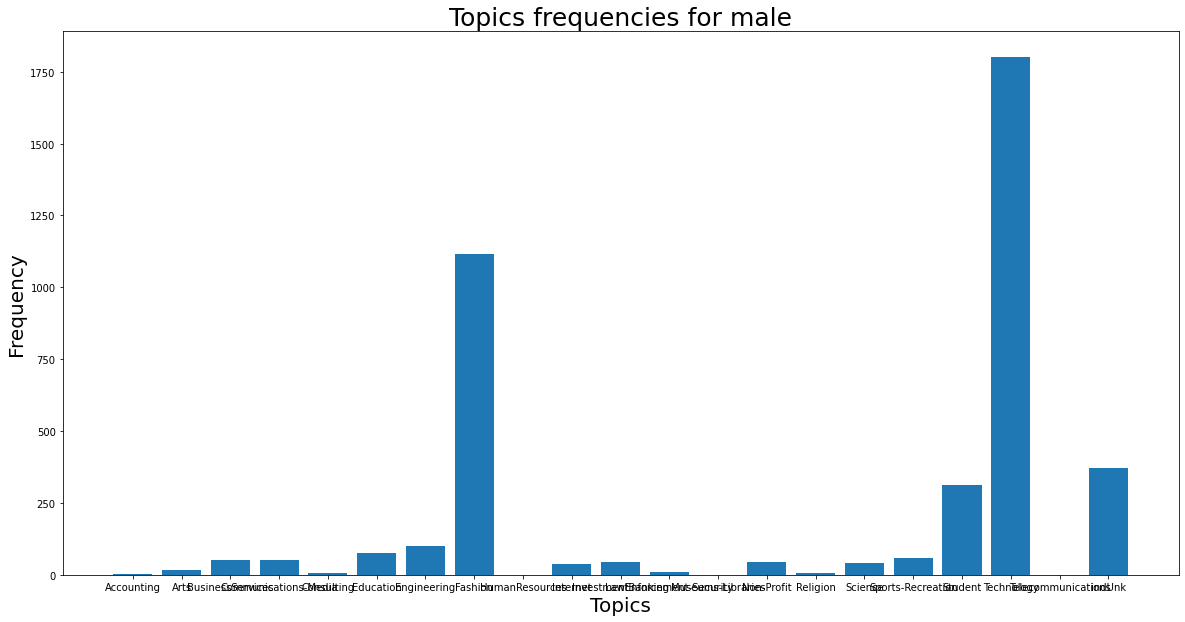

In [ ]:
plot_frequency_distribution(data_train_preprocessed, 'male')

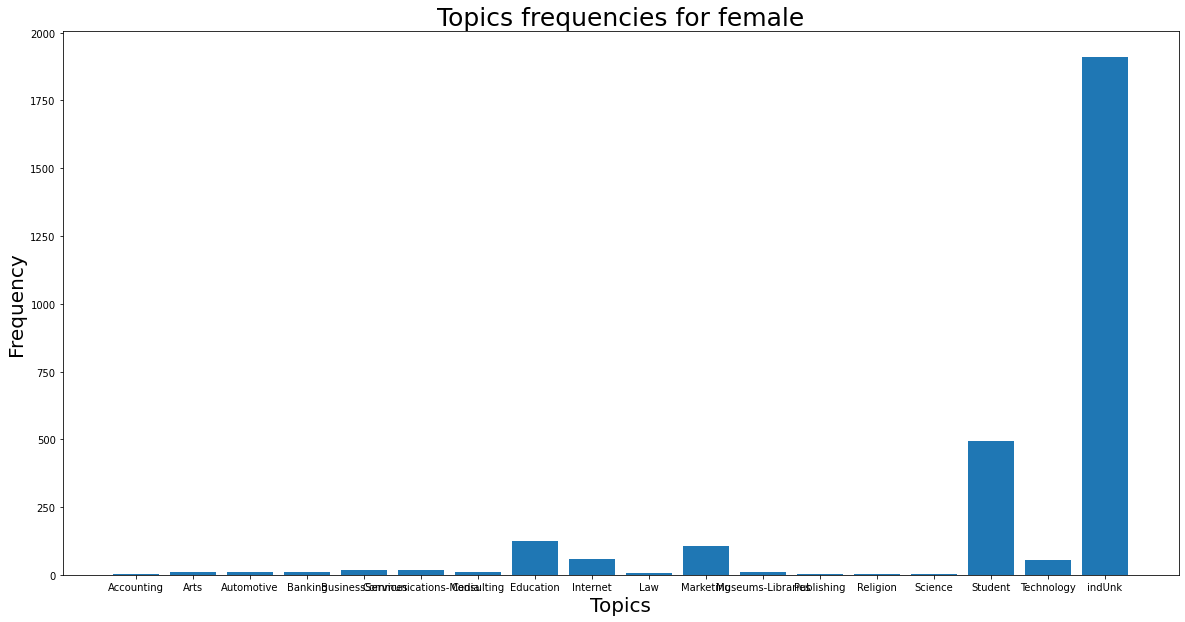

In [ ]:
plot_frequency_distribution(data_train_preprocessed, "female")

### 5.2. Classification traditionnelle à base de textes (35%)

In [ ]:
def tf_idf(processed_train_df, processed_val_df, N, n_grams) :
    # A partir des dataframes pré-traités de questions et de paragraphes, d'une taille de vocabulaire N et 
    # d'un couple n_grams, renvoie une matrice TF-IDF ainsi que son vectorizer associé
    processed_train_df_copy = processed_train_df.copy()
    processed_train_df_copy['processed_text'] = processed_train_df_copy['processed_text'].apply(lambda x: ' '.join(x))
    processed_val_df_copy = processed_val_df.copy()
    processed_val_df_copy['processed_text'] = processed_val_df_copy['processed_text'].apply(lambda x: ' '.join(x))
    vectorizer = TfidfVectorizer(smooth_idf=False, max_features = N, ngram_range = n_grams)
    vectorizer.fit(processed_train_df_copy['processed_text'])
    tfidf_train = vectorizer.transform(processed_train_df_copy['processed_text']) 
    tfidf_val = vectorizer.transform(processed_val_df_copy['processed_text'])
    print('Vocabulary :\n\n', vectorizer.get_feature_names())
    return tfidf_train, tfidf_val, vectorizer

In [ ]:
def logistic_regression_model(xtrain, ytrain) :
    model = LogisticRegression(max_iter = 1000)
    model.fit(xtrain,ytrain)
    return model

In [ ]:
def naive_bayes_classifier(xtrain, ytrain) :
    model = GaussianNB()
    model.fit(xtrain,ytrain)
    return model

In [ ]:
def compute_mape(y, ypred) :
    return np.sum(abs(y-ypred))/len(y)

In [ ]:
Y_train = data_train_preprocessed['gender'].apply(lambda sex: 0 if sex == 'male' else 1).to_numpy()
Y_val = data_val_preprocessed['gender'].apply(lambda sex: 0 if sex == 'male' else 1).to_numpy()

1. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame du contenu des blogues, pondéré avec TF-IDF.

In [ ]:
# Datasets and vectorizer for the unigram model
X_train_11, X_val_11, vectorizer_11 = tf_idf(data_train_preprocessed, data_val_preprocessed, max_features, (1,1))

Vocabulary :

 ['00', '000', '00am', '00pm', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '102', '107', '108', '10am', '10pm', '10th', '11', '110', '11am', '11pm', '11th', '12', '120', '125', '13', '130', '13th', '14', '15', '150', '15am', '15th', '16', '17', '17th', '18', '1860', '18th', '19', '1956', '1979', '1983', '1988', '1989', '1990', '1990s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '20th', '21', '21st', '22', '23', '24', '25', '250', '25th', '26', '27', '27th', '28', '28th', '29', '29th', '2am', '2b', '2day', '2nd', '2pm', '30', '300', '3000', '30am', '30pm', '30th', '31', '32', '33', '34', '35', '36', '3650', '37', '38', '39', '3am', '3pm', '3rd', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '4am', '4th', '50', '500', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5pm', '5th', '60', '600', '61', '62', '63', '64',

* Pour la régression logistique

In [ ]:
log_regression_model_11 = logistic_regression_model(X_train_11, Y_train)

In [ ]:
Y_val_predicted_lr_11 = log_regression_model_11.predict(X_val_11)

In [ ]:
compute_mape(Y_val, Y_val_predicted_lr_11)

0.199

* Pour le classificateur Naïve Bayes

In [ ]:
naive_bayes_model_11 = naive_bayes_classifier(X_train_11.toarray(), Y_train)

In [ ]:
Y_val_predicted_nb_11 = naive_bayes_model_11.predict(X_val_11.toarray())

In [ ]:
compute_mape(Y_val, Y_val_predicted_nb_11)

0.295

2. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame **et** bigramme du contenu des blogues, pondéré avec TF-IDF.

* Pour la régression logistique

In [ ]:
# Datasets and vectorizer for the unigram/bigram model
X_train_12, X_val_12, vectorizer_12 = tf_idf(data_train_preprocessed, data_val_preprocessed, max_features, (1,2))

Vocabulary :

 ['00', '00 pm', '000', '000 people', '00pm', '02', '03', '04', '05', '06', '07', '08', '09', '10', '10 000', '10 15', '10 30', '10 days', '10 minutes', '10 pm', '10 times', '10 year', '10 years', '100', '100 000', '1000', '101', '10th', '11', '11 30', '11pm', '11th', '12', '12 00', '12 30', '12 hours', '13', '130', '13th', '14', '14 year', '15', '15 minutes', '150', '16', '17', '18', '1860', '18th', '19', '1956', '1989', '1990', '1992', '1995', '1996', '1998', '1999', '19th', '1st', '20', '20 minutes', '20 years', '200', '200 000', '2000', '2001', '2002', '2003', '2004', '2005', '20th', '21', '21st', '22', '23', '24', '24 hours', '25', '250', '26', '27', '27th', '28', '29', '2am', '2day', '2nd', '30', '30 minutes', '30 morning', '300', '30am', '30pm', '31', '32', '33', '34', '34 pm', '35', '36', '37', '38', '39', '3rd', '40', '40 years', '400', '41', '41 pm', '42', '43', '44', '45', '45 minutes', '46', '47', '48', '49', '4am', '4th', '50', '50 000', '50 years', '500', '5

In [ ]:
log_regression_model_12 = logistic_regression_model(X_train_12, Y_train)

In [ ]:
Y_val_predicted_lr_12 = log_regression_model_12.predict(X_val_12)

In [ ]:
compute_mape(Y_val, Y_val_predicted_lr_12)

0.207

* Pour le classificateur Naïve-Bayes

In [ ]:
naive_bayes_model_12 = naive_bayes_classifier(X_train_12.toarray(), Y_train)

In [ ]:
Y_val_predicted_nb_12 = naive_bayes_model_12.predict(X_val_12.toarray())

In [ ]:
compute_mape(Y_val, Y_val_predicted_nb_12)

0.284

3. (5 points) Testez vos deux modèles et retournez les valeurs des métriques d’évaluation: précision globale (accuracy) et précision, rappel et F1-score par classe. Affichez aussi les macro moyennes pour toutes ces métriques.

In [ ]:
def evaluate_metrics(yval, ypred) :
    return {
        'Precision': precision_score(yval, ypred), 
        'Precision Macro': precision_score(yval, ypred, average='macro'), 
        'Accuracy': accuracy_score(yval, ypred), 
        'Recall': recall_score(yval, ypred),
        'Recall Macro': recall_score(yval, ypred, average='macro'),
        'F1': f1_score(yval, ypred), 
        'F1 Macro': f1_score(yval, ypred)
    }

In [ ]:
print('Métrique d\'évaluation pour le modèle de regression logistique: (unigrame)')
evaluate_metrics(Y_val, Y_val_predicted_lr_11)

Métrique d'évaluation pour le modèle de regression logistique: (unigrame)


{'Accuracy': 0.801,
 'F1': 0.7277701778385773,
 'F1 Macro': 0.7277701778385773,
 'Precision': 0.8134556574923547,
 'Precision Macro': 0.8042018257744091,
 'Recall': 0.6584158415841584,
 'Recall Macro': 0.778033424147784}

In [ ]:
print('Métrique d\'évaluation pour le classificateur Naive Bayes: (unigrame)')
evaluate_metrics(Y_val, Y_val_predicted_nb_11)

Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame)


{'Accuracy': 0.705,
 'F1': 0.669652855543113,
 'F1 Macro': 0.669652855543113,
 'Precision': 0.6114519427402862,
 'Precision Macro': 0.7029862453427458,
 'Recall': 0.7400990099009901,
 'Recall Macro': 0.7106535317961327}

In [ ]:
print('Métrique d\'évaluation pour le modèle de regression logistique: (unigrame et bigrame)')
evaluate_metrics(Y_val, Y_val_predicted_lr_12)

Métrique d'évaluation pour le modèle de regression logistique: (unigrame et bigrame)


{'Accuracy': 0.793,
 'F1': 0.721399730820996,
 'F1 Macro': 0.721399730820996,
 'Precision': 0.7905604719764012,
 'Precision Macro': 0.7924058033104396,
 'Recall': 0.6633663366336634,
 'Recall Macro': 0.7721194099275699}

In [ ]:
print('Métrique d\'évaluation pour le classificateur Naive Bayes: (unigrame et bigrame)')
evaluate_metrics(Y_val, Y_val_predicted_nb_12)

Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame et bigrame)


{'Accuracy': 0.716,
 'F1': 0.6823266219239373,
 'F1 Macro': 0.6823266219239373,
 'Precision': 0.6224489795918368,
 'Precision Macro': 0.7141656662665066,
 'Recall': 0.754950495049505,
 'Recall Macro': 0.7222739052428733}

4. (10 points) Trouvez les paramètres optimaux en utilisant un pipeline et GridSearch. Retournez la configuration optimale et sa performance pour chaque algorithme (Naive Bayes, Régression logistique) avec cette configuration en testant les paramètres suivants: 
- Modèle basé sur les mots ou les caractères
- Type de n-gramme (1, 2 et leur combinaison) 
- Utilisation ou non de TF-IDF
- Minuscule avec TF-IDF ou non
- Taille du vocabulaire: 5000, 10000, none
- Pour Naive Bayes, testez différentes valeurs du paramètre alpha (bayes__alpha)
- Pour la régression logistique, testez aussi différentes stratégies de régularisation (logistic_penalty)

* Régression logistique : N=None, modèle unigramme
* NB : N=10000, modèle unigramme/bigramme

In [ ]:
class CombinedAttributesAdder(TransformerMixin):
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        return X.toarray()

X_train = data_train_preprocessed[0:100]["processed_text"].apply(lambda x: " ".join(x))
X_valid = data_val_preprocessed[0:100]["processed_text"].apply(lambda x: " ".join(x))

Y_train = data_train_preprocessed[0:100]["gender"].apply(lambda sex: 0 if sex == "male" else 1)
Y_val = data_val_preprocessed[0:100]["gender"].apply(lambda sex: 0 if sex == "male" else 1)

NB_pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer(smooth_idf=False)),
    ('sparse_to_array', CombinedAttributesAdder()),
    ('nbayes', GaussianNB())
])

NB_param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)], 
    'tfidf__use_idf': [True, False],
    'tfidf__lowercase': [True, False],
    'tfidf__max_features': [5000, 10000, None],
    #'nbayes__alpha': [1, 2, 3]
}


NB_grid_search = GridSearchCV(NB_pipeline, NB_param_grid, cv=5,
            scoring='f1_macro',
            return_train_score=True)

NB_grid_search.fit(X_train, Y_train)

print(NB_grid_search.best_params_)
print(NB_grid_search.best_score_)

{'tfidf__analyzer': 'word', 'tfidf__lowercase': True, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}
0.5023195534367967


In [ ]:
logistic_pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer(smooth_idf=False)),
    ('sparse_to_array', CombinedAttributesAdder()),
    ('logistic', LogisticRegression(max_iter = 1000))
])

logistic_param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)], 
    'tfidf__use_idf': [True, False],
    'tfidf__lowercase': [True, False],
    'tfidf__max_features': [5000, 10000, None],
    #'logistic__penalty': [1, 2, 3]
}


logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5,
            scoring='f1_macro',
            return_train_score=True)

logistic_grid_search.fit(X_train, Y_train)

print(logistic_grid_search.best_params_)
print(logistic_grid_search.best_estimator_)

{'tfidf__analyzer': 'char', 'tfidf__lowercase': True, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (2, 2), 'tfidf__use_idf': True}
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=5000,
                                 ngram_range=(2, 2), smooth_idf=False)),
                ('sparse_to_array',
                 <__main__.CombinedAttributesAdder object at 0x7f6d4106cd00>),
                ('logistic', LogisticRegression(max_iter=1000))])


### 5.3. Classification neuronale (45%)

1. (10 points) Implémentez un modèle à deux couches Bi-LSTM avec Keras sans plongements pré-entrainés et entrainez-le sur l’ensemble d’entrainement (voir les points suivants). Assurez-vous que votre séquence maximale prenne en compte la plus longue séquence de votre ensemble de données d’entrainement.

In [ ]:
max_features = 5000
embedding_dim = 128

In [ ]:
def get_vocabulary(max_features):
    vectorizer = TextVectorization(max_tokens=max_features)
    vectorizer.adapt(data_train_preprocessed['processed_text'].apply(lambda x: ' '.join(x)).to_list())
    vocabulary = vectorizer.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    return word_index, vectorizer

def prepare_data(dataframe, vectorizer):
    y = dataframe['gender'].apply(lambda sex: 0 if sex == 'male' else 1).to_list()
    x = vectorizer(dataframe['processed_text'].apply(lambda x: ' '.join(x)).to_list())
    return x, np.asarray(y, dtype='float32')
    
def init_basic_model(vocab_length, embedding_dim):
    inputs = keras.Input(shape=(None,), dtype='int32')
    x = layers.Embedding(vocab_length, embedding_dim)(inputs)
    #Ajoute 2 LSTMs bidirectionels
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #Ajout d'un classificateur
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
vocabulary, vectorizer = get_vocabulary(max_features)
x_train, y_train = prepare_data(data_train_preprocessed, vectorizer)
x_valid, y_valid = prepare_data(data_val_preprocessed, vectorizer)
x_test, y_test = prepare_data(data_test_preprocessed, vectorizer)

basic_model = init_basic_model(max_features, embedding_dim)
basic_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 837,761
Trainable params: 837,761
Non-trainable params: 0
_________________________________________________________________


2. (2 points) Effectuez un «EarlyStopping» prenant en compte une «val_loss» minimale et en attendant 3 époques.

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

3. (2 points) En utilisant un ModelCheckpoint, sauvegardez votre meilleur modèle pour lequel la métrique «val_accuracy» soit maximale.

In [ ]:
basic_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./history_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
with tensorflow.device('/device:GPU:0'):
  his = basic_model.fit(
      x=x_train,
      y=y_train,
      batch_size=32,
      epochs=15,
      validation_data=(x_valid, y_valid),
      callbacks=[early_stopping_callback, basic_model_checkpoint_callback])

Epoch 1/15
219/219 [==============================] - 141s 607ms/step - loss: 0.5676 - accuracy: 0.7044 - val_loss: 0.4617 - val_accuracy: 0.7970
Epoch 2/15
219/219 [==============================] - 131s 598ms/step - loss: 0.3525 - accuracy: 0.8496 - val_loss: 0.4427 - val_accuracy: 0.8130
Epoch 3/15
219/219 [==============================] - 132s 603ms/step - loss: 0.2415 - accuracy: 0.8986 - val_loss: 0.5131 - val_accuracy: 0.7760
Epoch 4/15
219/219 [==============================] - 132s 603ms/step - loss: 0.1655 - accuracy: 0.9349 - val_loss: 0.6269 - val_accuracy: 0.7760
Epoch 5/15
219/219 [==============================] - 132s 603ms/step - loss: 0.1204 - accuracy: 0.9516 - val_loss: 0.6751 - val_accuracy: 0.7760


4. (5 points) Affichez dans une figure la fonction de perte / époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

In [ ]:
def generate_model_history(history, monitor, ylabel, title):
    plt.plot(history.history[monitor])
    plt.plot(history.history['val_' + monitor])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

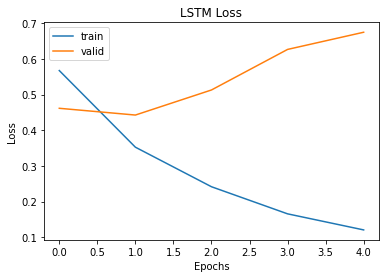

In [ ]:
generate_model_history(his, 'loss', 'Loss', 'LSTM Loss')

5. (5 points) Affichez dans une figure la précision globale (accuracy)/ époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

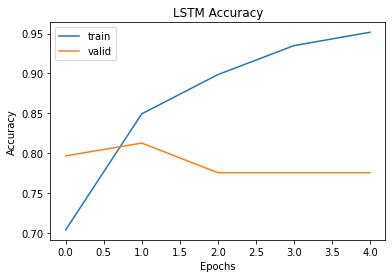

In [ ]:
generate_model_history(his, 'accuracy', 'Accuracy', 'LSTM Accuracy')

6. (2 points) Chargez le meilleur modèle retenu, et affichez les performances de ce meilleur modèle sur l’ensemble de test. Utilisez la métrique Accuracy. (Exemple: Accuracy: 0.82)

In [ ]:
basic_model.load_weights('./history_checkpoint')
scores = basic_model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

Accuracy: 78.1000018119812%


7. (10 points) En utilisant des plongements lexicaux pré-entrainés GLOVE, implémentez un modèle Bi-LSTM à deux couches avec Keras utilisant ces plongements et avec les mêmes critères d’EarlyStopping et de ModelCheckpoint que précédemment, et entrainez-le sur l’ensemble d’entrainement. Sauvegardez votre meilleur modèle. 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-10-18 00:28:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-18 00:28:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-18 00:28:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
def get_embeddings_index_from_glove(glove_file):
    embeddings_index = {}
    with open(glove_file) as file:
        for line in file:
            elements = line.split(' ')
            word = elements[0]
            coefs = [float(element) for element in elements[1:]]
            embeddings_index[word] = coefs
    return embeddings_index

def get_embedding_matrix(max_features, embedding_dimension, vocabulary, embedding_index):
    embedding_matrix = np.zeros((max_features, embedding_dimension))
    hits = 0
    misses = 0
    for word, i in vocabulary.items():
        if word not in embeddings_index:
            misses += 1
            continue
        embedding_matrix[i] = embeddings_index[word]
        hits += 1
    print(f'Succeeded to convert {hits} words! Missed {misses} words!')
    return embedding_matrix

def initi_keras_model_glove(max_features, embedding_dim, embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int32")
    embedding_layer = layers.Embedding(
        max_features,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
    x = embedding_layer(inputs)
    #Ajoute 2 LSTMs bidirectionels
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #Ajout d'un classificateur
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
embedding_dim = 200
vocabulary, vectorizer = get_vocabulary(max_features)
embeddings_index = get_embeddings_index_from_glove('glove.6B.200d.txt')
embedding_matrix = get_embedding_matrix(max_features + 2, embedding_dim, vocabulary, embeddings_index)
model_with_glove = initi_keras_model_glove(max_features + 2, embedding_dim, embedding_matrix)

Succeeded to convert 4949 words! Missed 51 words!
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 200)         1000400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         135680    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,235,025
Trainable params: 234,625
Non-trainable params: 1,000,400
_________________________________________________________________


In [ ]:
model_glove_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./history_glove_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
model_with_glove.compile("adam", "binary_crossentropy", metrics=["accuracy"])
with tensorflow.device('/device:GPU:0'):
    his_with_glove = model_with_glove.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=15,
        validation_data=(x_valid, y_valid),
        callbacks=[early_stopping_callback, model_glove_checkpoint_callback])

Epoch 1/15
219/219 [==============================] - 137s 601ms/step - loss: 0.6321 - accuracy: 0.6537 - val_loss: 0.5925 - val_accuracy: 0.6820
Epoch 2/15
219/219 [==============================] - 130s 592ms/step - loss: 0.5717 - accuracy: 0.7057 - val_loss: 0.5486 - val_accuracy: 0.7210
Epoch 3/15
219/219 [==============================] - 130s 595ms/step - loss: 0.5308 - accuracy: 0.7330 - val_loss: 0.5290 - val_accuracy: 0.7260
Epoch 4/15
219/219 [==============================] - 130s 595ms/step - loss: 0.4910 - accuracy: 0.7669 - val_loss: 0.5887 - val_accuracy: 0.6490
Epoch 5/15
219/219 [==============================] - 132s 602ms/step - loss: 0.5092 - accuracy: 0.7350 - val_loss: 0.4985 - val_accuracy: 0.7520
Epoch 6/15
219/219 [==============================] - 132s 603ms/step - loss: 0.4338 - accuracy: 0.7924 - val_loss: 0.5005 - val_accuracy: 0.7560
Epoch 7/15
219/219 [==============================] - 132s 602ms/step - loss: 0.3921 - accuracy: 0.8160 - val_loss: 0.4932 -

8. (2 points) De la même manière que précédemment, affichez dans deux figures la fonction de perte et la précision globale (accuracy) / époque sur le jeu de données d’entrainement (train) et de validation (val).

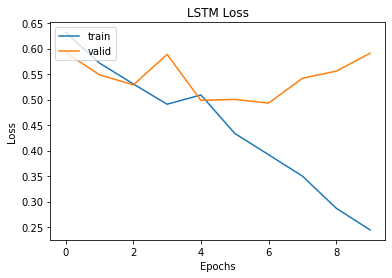

In [ ]:
generate_model_history(his_with_glove, 'loss', 'Loss', 'LSTM Loss')

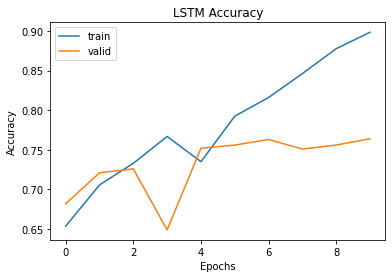

In [ ]:
generate_model_history(his_with_glove, 'accuracy', 'Accuracy', 'LSTM Accuracy')

9. (2 points) Affichez les performances de votre meilleur modèle à base de plongements sur l’ensemble de test. Utilisez la métrique de précision globale (Accuracy).

In [ ]:
model_with_glove.load_weights('./history_glove_checkpoint')
scores = model_with_glove.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

Accuracy: 74.34999942779541%


10. (5 points) Si ce n’est pas déjà le cas, tentez de dépasser les performances de votre meilleur modèle traditionnel en créant un nouveau modèle Bi-LSTM (vous pouvez ajouter des couches, utiliser du dropout, utiliser d’autres modèles de plongements, etc.)

In [ ]:
# Nabil's model --> add layers and dropout
def init_improved_lstm_model(max_features, embedding_dim, embedding_matrix):
    model = keras.Sequential()
    model.add(layers.Embedding(
        max_features,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    ))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    model.summary()
    return model

In [ ]:
improved_model = init_improved_lstm_model(max_features + 2, embedding_dim, embedding_matrix)
improved_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./improved_model_history_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
improved_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
with tensorflow.device('/device:GPU:0'):
    improved_his = improved_model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=15,
        validation_data=(x_valid, y_valid),
        callbacks=[early_stopping_callback, improved_model_checkpoint_callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 200)         1000400   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, None, 128)         135680    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,235,025
Trainable params: 234,625
Non-trainable params: 1,000,400
______________________________________

In [ ]:
improved_model.load_weights('./improved_model_history_checkpoint')
scores = model_with_glove.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

Accuracy: 73.60000014305115%


In [1]:
# Simon's model --> New embeddings with fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
!unzip -q wiki-news-300d-1M-subword.vec.zip

In [2]:
def load_fasttext_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [ ]:
embedding_dim = 300
fasttext_embeddings_index = load_fasttext_vectors("wiki-news-300d-1M.vec")
fasttext_embedding_matrix = get_embedding_matrix(max_features + 2, embedding_dim, vocabulary, fasttext_embeddings_index)
model_with_fasttext = initi_keras_model_glove(max_features + 2, embedding_dim, fasttext_embedding_matrix)

In [ ]:
fasttext_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./fasttext_model_history_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

model_with_fasttext.compile("adam", "binary_crossentropy", metrics=["accuracy"])
with tensorflow.device('/device:GPU:0'):
    fasttext_his = model_with_fasttext.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=15,
        validation_data=(x_valid, y_valid),
        callbacks=[early_stopping_callback, fasttext_model_checkpoint_callback])

In [ ]:
model_with_fasttext.load_weights('./fasttext_model_history_checkpoint')
scores = model_with_fasttext.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

### 5.4. Évaluation (10%)

1. (4 points) Affichez une table récapitulative comparant les performances de vos différents modèles sur l’ensemble de test.

| Modèle | Régression Logistique | Modèle Naïve Bayes | Bi-LSTM classique | Bi-LSTM avec Glove | Bi-LSTM avec FastText | 
|-----------|-----------|-----------|-----------|-----------|-----------| 
| **Accuracy** | cellule 1 | cellule 2 | cellule 3 | cellule 4 | cellule 5 |

2. (6 points) Indiquez votre conclusion dans une cellule (Meilleur algorithme? Meilleure configuration pour l’apprentissage machine «traditionnel»? Effets du GridSearch? Meilleur modèle Bi-LSTM?)

## LIVRABLES
Vous devez remettre sur Moodle:
1. Le code: Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source._ Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié;
4. Un document _contributions.txt_: Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisseeffectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- **Règle 1:**  Le plagiat de code est bien évidemment interdit.
- **Règle 2:** Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- **Règle 3:**  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
